<a href="https://colab.research.google.com/github/srivatsan88/End-to-End-Time-Series/blob/master/Multivariate_Time_Series_using_VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from math import sqrt
import numpy as np
import pandas as pd
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from xgboost import XGBRegressor

# load dataset
stock_price_df = read_csv('./data/VN30_price.csv', header=0, index_col=0)
values = stock_price_df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
stock_price_df.head()

,BID,BVH,CTG,FPT,GAS,HPG,KDH,MBB,MSN,MWG,...,PNJ,REE,SBT,SSI,STB,TCH,VCB,VIC,VNM,VN30
2016-12-30,10531.3,58200.0,15050.0,15852.0,60600.0,6770.2,9221.5,5151.6,43200.0,18328.0,...,22097.6,24650.0,20035.1,9521.4,9450.0,12181.1,26307.0,34711.0,99213.0,628.21
2017-01-03,11235.8,59300.0,16100.0,16158.2,60100.0,6903.6,9198.4,5059.6,43600.0,18411.0,...,22164.0,25000.0,21261.8,9740.0,8790.0,12181.1,27643.0,34380.0,100082.0,633.89
2017-01-04,11458.3,60100.0,16400.0,16302.3,61500.0,6903.6,9198.4,5004.4,42333.0,18481.0,...,22230.5,25000.0,20771.1,9740.0,8200.0,12109.0,27457.0,34752.0,100240.0,632.70
2017-01-05,11421.2,61100.0,16500.0,16248.3,61500.0,6919.3,8944.8,4967.6,42067.0,18540.0,...,22263.7,25300.0,20607.6,9764.3,8580.0,12289.2,27569.0,34959.0,100082.0,634.83
2017-01-06,11680.8,61400.0,16650.0,16194.3,60400.0,6809.4,9083.2,5059.6,42133.0,18540.0,...,22895.1,25000.0,20525.8,9861.4,8780.0,12217.1,28125.0,35620.0,99529.0,636.34


In [2]:
column_names = stock_price_df.columns

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('{}(t-{})'.format(column_names[j], i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('{}(t)'.format(column_names[j])) for j in range(n_vars)]
		else:
			names += [('{}(t+{})'.format(column_names[j], i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [4]:
Shift_df = stock_price_df.copy()

In [5]:
for col in column_names:
    stock_price_df["Diff" + column_names] = stock_price_df[column_names].diff()
    # copy_df.fillna(method='ffill', inplace=True)
# stock_price_df.dropna(inplace=True)

In [6]:
n_days_lag = 10
n_features = len(column_names)

reframed = series_to_supervised(stock_price_df[[f"Diff{col}" for col in column_names]], n_days_lag, 1)


In [7]:
reframed.head()

,BID(t-10),BVH(t-10),CTG(t-10),FPT(t-10),GAS(t-10),HPG(t-10),KDH(t-10),MBB(t-10),MSN(t-10),MWG(t-10),...,PNJ(t),REE(t),SBT(t),SSI(t),STB(t),TCH(t),VCB(t),VIC(t),VNM(t),VN30(t)
2017-01-17,704.5,1100.0,1050.0,306.2,-500.0,133.4,-23.1,-92.0,400.0,83.0,...,-66.5,0.0,0.0,97.2,280.0,-360.3,1187.0,-165.0,-316.0,4.84
2017-01-18,222.5,800.0,300.0,144.1,1400.0,0.0,0.0,-55.2,-1267.0,70.0,...,99.7,750.0,0.0,-97.2,210.0,-144.2,-482.0,-455.0,-79.0,-4.44
2017-01-19,-37.1,1000.0,100.0,-54.0,0.0,15.7,-253.6,-36.8,-266.0,59.0,...,0.0,0.0,-245.3,-121.4,140.0,-108.1,-223.0,-82.0,0.0,-2.10
2017-01-20,259.6,300.0,150.0,-54.0,-1100.0,-109.9,138.4,92.0,66.0,0.0,...,0.0,-150.0,245.3,0.0,-90.0,756.8,0.0,0.0,790.0,3.28
2017-01-23,333.7,200.0,450.0,90.0,100.0,-39.2,0.0,-18.4,-400.0,-129.0,...,0.0,-750.0,-81.7,-72.9,50.0,0.0,75.0,0.0,790.0,1.14


In [8]:
# split into train and test sets
n_obs = n_days_lag * n_features

values = reframed.values
n_train_days = int(len(reframed.index) * 0.8)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
#y is the VN30 price
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
# reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], n_days_lag, n_features))
# test_X = test_X.reshape((test_X.shape[0], n_days_lag, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1191, 220) (1191, 22) (298, 220) (298, 22)


In [9]:
test_df = stock_price_df[n_train_days:]
train_df = stock_price_df[:n_train_days]

In [10]:
xgboost_model = XGBRegressor()
xgboost_model.fit(train_X, train_y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [11]:
train_idx = stock_price_df.index <= reframed[:n_train_days].index[-1]
test_idx = ~train_idx

train_idx[:n_days_lag+1] = False

In [12]:
xgboost_model.score(train_X, train_y)

0.9999988004190103

In [13]:
xgboost_model.score(test_X, test_y)

-0.596706325232056

In [14]:
xgboost_model.predict(train_X)[:, 1].shape

(1191,)

In [15]:
for i, col in enumerate(column_names):
    stock_price_df[f'Shift{col}'] = stock_price_df[col].shift(1)
    prev = stock_price_df[f'Shift{col}']
    stock_price_df.loc[train_idx, f'{col}-XGB_1_step_train'] = prev[train_idx] + xgboost_model.predict(train_X)[:, i]
    stock_price_df.loc[test_idx, f'{col}-XGB_1_step_test'] = prev[test_idx] + xgboost_model.predict(test_X)[:, i]

In [16]:
stock_price_df[['ShiftVN30', 'VN30']]

,ShiftVN30,VN30
2016-12-30,NaN,628.21
2017-01-03,628.21,633.89
2017-01-04,633.89,632.70
2017-01-05,632.70,634.83
2017-01-06,634.83,636.34
...,...,...
2022-12-26,1034.13,987.77
2022-12-27,987.77,1007.36
2022-12-28,1007.36,1013.95
2022-12-29,1013.95,1008.30


In [17]:
observe_date = reframed[n_train_days-10:].index[0]

<Axes: >

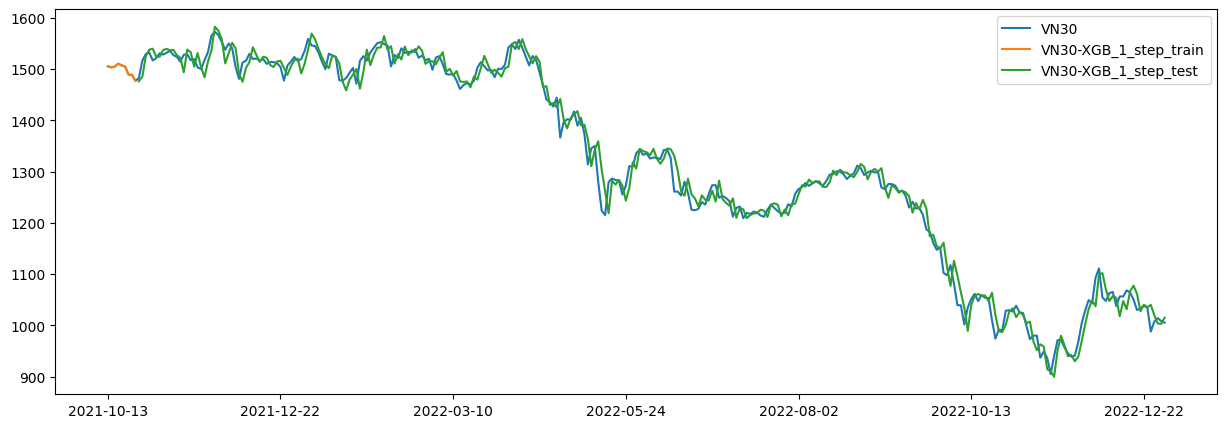

In [18]:
stock_price_df[stock_price_df.index > observe_date][['VN30', 'VN30-XGB_1_step_train', 'VN30-XGB_1_step_test']].plot(figsize=(15,5))

In [19]:
test_X[[0], :].shape

(1, 220)

In [20]:
n_observe_days = 300
multistep_forecasting = []
last_x = test_X[[0]]
while len(multistep_forecasting) < n_observe_days:
    p = xgboost_model.predict(last_x)
    multistep_forecasting.append(p)
    last_x = np.roll(last_x, -n_features)
    for i in range(n_features):
        last_x[0, -(n_features-i)] = p[0, i]


In [21]:
import copy
multistep_idx = copy.deepcopy(test_idx)
multistep_idx[n_train_days+n_days_lag+1+n_observe_days:] = False
multistep_idx.sum()

298

In [22]:
for i, col in enumerate(column_names):
    last_train = stock_price_df.iloc[n_train_days+n_days_lag][col]
    stock_price_df.loc[multistep_idx, f'{col}-XGB_multistep'] = last_train + np.cumsum([p[0,i] for  p in multistep_forecasting])

ValueError: NumPy boolean array indexing assignment cannot assign 300 input values to the 298 output values where the mask is true

<Axes: xlabel='Date'>

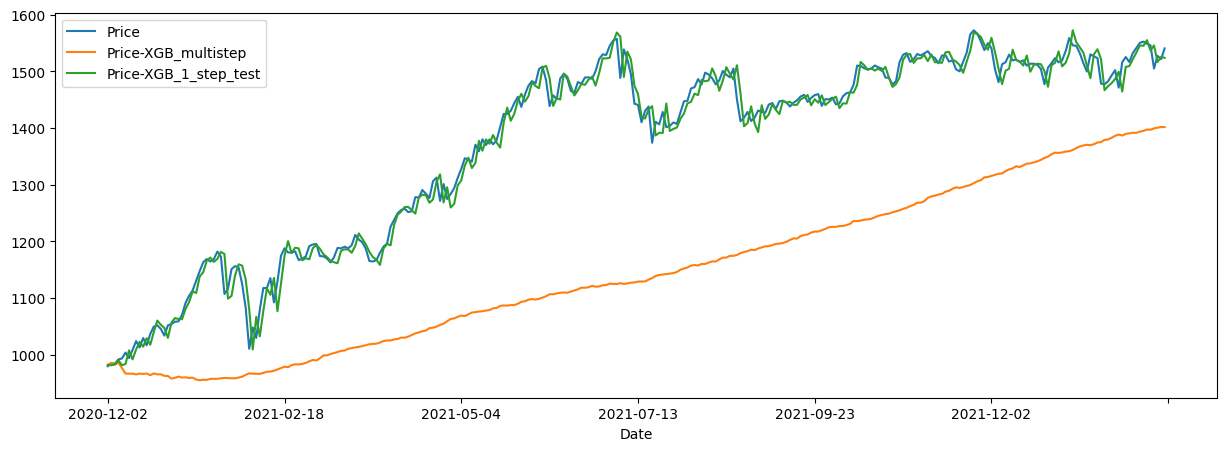

In [ ]:
stock_price_df[multistep_idx][['Price', 'Price-XGB_multistep', 'Price-XGB_1_step_test']].plot(figsize=(15,5))

In [ ]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
def adjust(val, length= 6): return str(val).ljust(length)


In [ ]:
print('\nForecast Accuracy of One-step ahead: VN30')
test = stock_price_df.copy()[['VN30-XGB_1_step_test', 'VN30']]
test.dropna(inplace=True)
accuracy_prod = forecast_accuracy(test['VN30-XGB_1_step_test'].values, test['VN30'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of One-step ahead: VN30
mape   :  0.0127
me     :  1.4948
mae    :  16.0431
mpe    :  0.0013
rmse   :  21.7196
corr   :  0.9938
minmax :  0.0125


In [ ]:
import pickle

In [ ]:
# xgboost_model.save_model('save/xgboost.json')

In [ ]:
# with open('save/xgboost.pkl', 'wb') as file:
#     pickle.dump(xgboost_model, file)
